In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl


%load_ext autoreload
%autoreload 2




/tmp/ipykernel_1661476/3259227615.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# # !pip install -Uq tfp-nightly[jax] > /dev/null
# from tensorflow_probability.substrates import jax as tfp
# tfd = tfp.distributions
# tfb = tfp.bijectors
# tfpk = tfp.math.psd_kernels




In [3]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 13.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 14.5, 48
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [4]:
import pickle as pk
z_array_fit = np.array([0.001, 0.5, 1.0])
snap_num_fit = np.array([32, 28, 26])
lgM_bin_min = jnp.array([13.0, 13.5, 14.0])
lgM_bin_max = jnp.array([13.5, 14.0, 14.5])
lgM_bin_mean = 0.5*(lgM_bin_min + lgM_bin_max)

# df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps_lite.pkl', 'rb'))
df_all_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps.pkl', 'rb'))
all_sims_names = list(df_all_data.keys())
jsim = 0


In [5]:
import scipy.interpolate as interp
# lgM_bin_min = jnp.array([11.7, 12.7, 13.3, 13.7, 14.3, 14.7])
# lgM_bin_max = jnp.array([12.0, 13.0, 13.6, 14.0, 14.7, 15.0])

z_array_fit = np.array([0.001, 0.5, 1.0])
snap_num_fit = np.array([32, 28, 26])

# z_array_fit = np.array([0.001])
# snap_num_fit = np.array([32])

# z_array_fit = np.array([0.5])
# snap_num_fit = np.array([28])

# z_array_fit = np.array([1.0])
# snap_num_fit = np.array([26])

lgM_bin_min = jnp.array([13.0, 13.5, 14.0])
lgM_bin_max = jnp.array([13.5, 14.0, 14.5])

lgM_bin_mean = 0.5*(lgM_bin_min + lgM_bin_max)
# zmean = 0.0015

import pickle as pk
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_32.pkl','rb'))
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_32.pkl','rb'))
df_at = df_all_data[all_sims_names[jsim]][snap_num_fit[0]]
# df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profs_highT.pk','rb'))
# print(df_at.keys())

dg_val = 3
x_array_data_all = df_at['r_r200c'][::dg_val]

xmin, xmax = 0.05, 1.0
indselx = np.where((x_array_data_all > xmin) & (x_array_data_all < xmax))[0]
x_array_data = x_array_data_all[indselx]

# lgmass_all = df_at['lgmass_all']
rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
Pe_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

sig_rho_dmb_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
sig_ne_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))
sig_Pe_gas_dv = np.zeros((len(z_array_fit), len(lgM_bin_min), len(x_array_data)))

for jz in range(len(z_array_fit)):
    snap_num_jz = snap_num_fit[jz]
    print('snap_num_jz = ' + str(snap_num_jz))
    # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_lowTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))
    # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
    df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
    M_dmo_all = df_at['M_dmo']
    rho_dmb_all = df_at['rho_dmb_all']
    # rho_gas_all = df_at['rho_gas_all']
    ne_all = df_at['ne_all']    
    Pe_all = df_at['P_all']
    lgM_dmo_all = np.log10(M_dmo_all)
    for jM in range(len(lgM_bin_min)):
        indselM = np.where((lgM_dmo_all > lgM_bin_min[jM]) & (lgM_dmo_all < lgM_bin_max[jM]))[0]
        print(indselM.shape)

        rho_dmb_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
        ne_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
        Pe_dv_all_jM = np.zeros((len(indselM), len(x_array_data)))
        for jbM in range(len(indselM)):
            rho_dmb_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(rho_dmb_all[indselM[jbM],:]))
            rho_dmb_dv_all_jM[jbM, :] = np.exp(rho_dmb_interp(np.log(x_array_data)))

            ne_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(ne_all[indselM[jbM],:]))
            ne_dv_all_jM[jbM, :] = np.exp(ne_interp(np.log(x_array_data)))

            Pe_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(Pe_all[indselM[jbM],:]))
            Pe_dv_all_jM[jbM, :] = np.exp(Pe_interp(np.log(x_array_data)))
        


        rho_dmb_dv[jz, jM, :] = np.mean(rho_dmb_dv_all_jM, axis=0)
        ne_dv[jz, jM, :] = np.mean(ne_dv_all_jM, axis=0)
        Pe_dv[jz, jM, :] = np.mean(Pe_dv_all_jM, axis=0)

        sig_rho_dmb_dv[jz, jM, :] = np.std(rho_dmb_dv_all_jM, axis=0)
        sig_ne_dv[jz, jM, :] = np.std(ne_dv_all_jM, axis=0)
        sig_Pe_gas_dv[jz, jM, :] = np.std(Pe_dv_all_jM, axis=0)


dmb_dv_flatten = rho_dmb_dv.flatten()
gas_dv_flatten = ne_dv.flatten()
Pgas_dv_flatten = Pe_dv.flatten()
sig_dmb_dv_flatten = sig_rho_dmb_dv.flatten()
sig_gas_dv_flatten = sig_ne_dv.flatten()
sig_Pgas_dv_flatten = sig_Pe_gas_dv.flatten()

dv_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pgas_dv_flatten))
ind_finite = jnp.where(jnp.isfinite(dv_combined))[0]
dv_combined = dv_combined[ind_finite]
# sigma_value_combined = 0.05*dv_combined
sigma_value_combined = jnp.concatenate((sig_dmb_dv_flatten, sig_gas_dv_flatten, sig_Pgas_dv_flatten))
sigma_value_combined = sigma_value_combined[ind_finite]
# sigma_value_combined = 0.05*dv_combined


# sigma_value_combined = sigma_value_combined/dv_combined
# dv_combined = jnp.log(dv_combined)

cov_combined = jnp.diag(sigma_value_combined**2)
# precision_combined = jnp.linalg.inv(cov_combined)
precision_combined = jnp.diag(1./sigma_value_combined**2)




snap_num_jz = 32
(157,)


/tmp/ipykernel_1362472/2278496123.py:66: RuntimeWarning: divide by zero encountered in log
  rho_dmb_interp = interp.interp1d(np.log(df_at['r_r200c']), np.log(rho_dmb_all[indselM[jbM],:]))


(61,)
(16,)
snap_num_jz = 28
(124,)
(50,)
(11,)
snap_num_jz = 26
(94,)
(22,)
(4,)


Text(0.5, 0, '$r/r_{200c}$')

<Figure size 640x480 with 0 Axes>

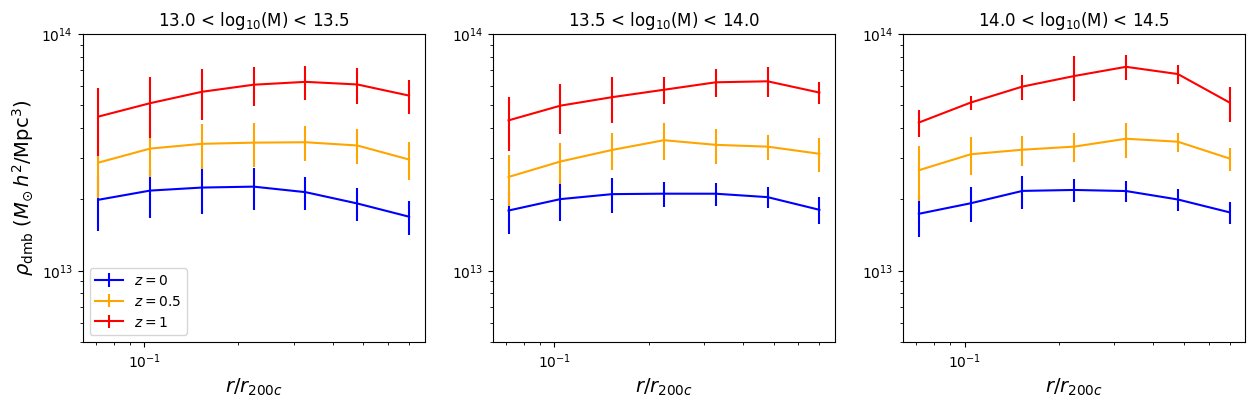

In [6]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
indM = 0
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$z=0$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$z=0.5$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$z=1$')
pl.ylim(5e12, 1e14)


# pl.title('Total density')
pl.title('13.0 < log$_{10}$(M) < 13.5')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)

# add subplot to the center:
pl.subplot(1, 3, 2)
# indM = 0
# pl.errorbar(x_array_data, rho_gas_dv[0,indM,:], sig_rho_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[1,indM,:], sig_rho_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[2,indM,:], sig_rho_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 1
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
pl.ylim(5e12, 1e14)
# pl.title('Gas density')
pl.title('13.5 < log$_{10}$(M) < 14.0')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e11, 1e15)
# pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
# indM = 0
# pl.errorbar(x_array_data, P_gas_dv[0,indM,:], sig_P_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[1,indM,:], sig_P_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[2,indM,:], sig_P_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 2
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[0,indM,:], (x_array_data**2)*sig_rho_dmb_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[1,indM,:], (x_array_data**2)*sig_rho_dmb_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*rho_dmb_dv[2,indM,:], (x_array_data**2)*sig_rho_dmb_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')


# pl.title('Electron pressure')
pl.title('14.0 < log$_{10}$(M) < 14.5')
pl.ylim(5e12, 1e14)
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()








Text(0.5, 0, '$r/r_{200c}$')

<Figure size 640x480 with 0 Axes>

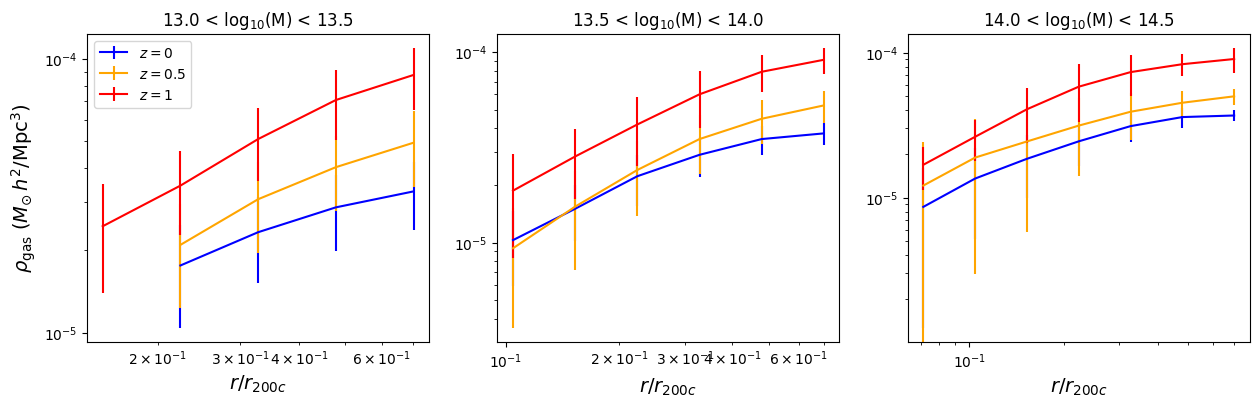

In [7]:
# # rho_dmb_dv.shape

pl.figure()
# set size of the figure:
pl.figure(figsize=(15, 4))
# add subplot to the left:
pl.subplot(1, 3, 1)
indM = 0
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$z=0$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$z=0.5$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$z=1$')
# pl.ylim(5e12, 1e14)
# pl.ylim(2e11, 1e13)

# pl.title('Total density')
pl.title('13.0 < log$_{10}$(M) < 13.5')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e16)
# pl.ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# add subplot to the center:
pl.subplot(1, 3, 2)
# indM = 0
# pl.errorbar(x_array_data, rho_gas_dv[0,indM,:], sig_rho_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[1,indM,:], sig_rho_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, rho_gas_dv[2,indM,:], sig_rho_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 1
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')
# pl.ylim(5e12, 1e14)
# pl.ylim(2e11, 1e13)
# pl.title('Gas density')
pl.title('13.5 < log$_{10}$(M) < 14.0')
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e11, 1e15)
# pl.ylabel(r'$\rho_{\rm gas}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=14)
# pl.legend()


# add subplot to the right:
pl.subplot(1, 3, 3)
# indM = 0
# pl.errorbar(x_array_data, P_gas_dv[0,indM,:], sig_P_gas_dv[0,indM,:],ls='-' , color='b', label='Total mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[1,indM,:], sig_P_gas_dv[1,indM,:],ls='-', color='orange', label='Gas mass, sims')
# pl.errorbar(x_array_data, P_gas_dv[2,indM,:], sig_P_gas_dv[2,indM,:],ls='-', color='r', label='Gas mass, sims')
indM = 2
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[0,indM,:], (x_array_data**2)*sig_ne_dv[0,indM,:],ls='-' , color='b', label=r'$13.0 < log_{10}(M) < 13.3$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[1,indM,:], (x_array_data**2)*sig_ne_dv[1,indM,:],ls='-', color='orange', label=r'$13.5 < log_{10}(M) < 13.8$')
pl.errorbar(x_array_data, (x_array_data**2)*ne_dv[2,indM,:], (x_array_data**2)*sig_ne_dv[2,indM,:],ls='-', color='r', label=r'$14.0 < log_{10}(M) < 14.3$')


# pl.title('Electron pressure')
pl.title('14.0 < log$_{10}$(M) < 14.5')
# pl.ylim(2e11, 1e13)
# pl.plot(BCMP_test_vary.r_array, rho_gas_dv[-1], ls='-' )
# pl.plot(BCMP_test_vary.r_array, BCMP_test_vary.rho_dmb_mat[:,indc,0,indM_min], ls='--' )
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r/r_{200c}$', size=14)
# pl.ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=14)
# pl.xlim(5e-2, 1)
# pl.ylim(1e12, 2e17)
# pl.legend()








In [8]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)
rho_dmb = BCMP_test.rho_dmb_mat_physical
# rho_gas = BCMP_test.rho_gas_mat_physical
ne_gas = BCMP_test.ne_mat_physical
Pe_gas = BCMP_test.Pe_mat_physical




In [9]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import mass_function
import scipy.interpolate as interpolate

cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)


masks_all = np.zeros(( len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
dndlnM_jb_repeat_all = np.zeros((len(z_array_fit), len(lgM_bin_min),len(x_array_data), halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
# M_new = np.zeros_like(BCMP_test.M_array)
norm_value_all = np.zeros((len(z_array_fit),len(lgM_bin_min)))


for jz in range(len(z_array_fit)):
    print('jz = ' + str(jz))
    zmean = z_array_fit[jz]

    cmean_array = concentration.concentration(10**lgM_bin_mean, '200c', zmean, model = 'diemer19')
    cmean_array = jnp.array(cmean_array)

    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)
    # dndlnM_th = mass_function.massFunction(M200c_array, zmean, mdef = '200c', model = 'tinker08', q_out='dndlnM')
    # dndlnM_th = jnp.array(dndlnM_th)
    snap_num_jz = snap_num_fit[jz]    
    # df_at = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_highTAGN_zs_' + str(snap_num_jz) + '.pkl','rb'))    
    df_at = df_all_data[all_sims_names[jsim]][snap_num_jz]
    M_dmo_all = df_at['M_dmo']
    zmean = z_array_fit[0]
    # len(M_dmo_all)
    # vol = 100**3
    lg10_Mmin, lg10_Mmax, nM = halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']
    M200c_array = jnp.logspace(lg10_Mmin, lg10_Mmax, nM)

    lg10Mbins_all = np.linspace(12.8, 15.0, 11)
    # lg10Mbins_all = np.array([13.0, 13.5, 14.0, 14.5 ])
    lg10Mbins_cent = 0.5*(lg10Mbins_all[1:] + lg10Mbins_all[:-1])

    hist_dmo = np.histogram(np.log10(M_dmo_all), bins=lg10Mbins_all)
    # get dn/dlnM from this histogram:
    vol = 100**3
    n_hist = hist_dmo[0]/vol
    n_hist = n_hist/np.diff(lg10Mbins_all)
    n_hist = n_hist/np.log(10)

    f_nhist = interpolate.interp1d(np.log(10**lg10Mbins_cent), np.log(n_hist + 1e-20), kind='cubic')

    dndlnM_th = jnp.exp(jnp.array(f_nhist(np.log(M200c_array))))

    # dndlnM_jb_repeat_all = {}
    for jb in range(len(lgM_bin_min)):
        lgM_min_jb = lgM_bin_min[jb]
        lgM_max_jb = lgM_bin_max[jb]
        cmean_jb = cmean_array[jb]
        c_array_th = jnp.exp(jnp.linspace(jnp.log(halo_params_dict['cmin']), jnp.log(halo_params_dict['cmax']), halo_params_dict['nc']))
        indc = jnp.argmin(jnp.abs(c_array_th - cmean_jb))
        print(indc, cmean_jb)
        # lgM_array_th = jnp.log10(jnp.logspace(halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM']))
        M_array_th = BCMP_test.M_array
        # M_array_th = BCMP_test.Mdmb_r200_mat[indc, 0, :]
        lgM_array_th = jnp.log10(M_array_th)
        indM_min = jnp.argmin(jnp.abs(lgM_array_th - lgM_min_jb))
        indM_max = jnp.argmin(jnp.abs(lgM_array_th - lgM_max_jb))
        # mask = jnp.zeros((halo_params_dict['nr'], halo_params_dict['nc'], halo_params_dict['nz'], halo_params_dict['nM']))
        # mask = jax.ops.index_update(mask, jax.ops.index[:, indc, 0, indM_min:indM_max+1], 1)
        # mask = mask.at[:, indc, 0, indM_min:indM_max+1].set(1)
        masks_all[jz, jb,:, indc, jz, indM_min:indM_max+1] = 1
        print(jz, jb, indc, jz, indM_min,indM_max+1)
        dndlnM_jb_repeat = jnp.tile(dndlnM_th.reshape(1,1,1,masks_all.shape[-1]), (masks_all.shape[-4],masks_all.shape[-3],masks_all.shape[-2], 1))
        # dndlnM_jb_repeat *= mask
        # dndlnM_jb_repeat_all[jb] = dndlnM_jb_repeat
        norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])
        norm_value_all[jz,jb] = norm_value
        print(norm_value)
        dndlnM_jb_repeat_all[jz,jb,...] = dndlnM_jb_repeat * masks_all[jz,jb,...]

masks_all = jnp.array(masks_all.astype(int))
dndlnM_jb_repeat_all = jnp.array(dndlnM_jb_repeat_all)
norm_value_all = jnp.array(norm_value_all)




jz = 0
16 5.365105606729137
0 0 16 0 0 17


/tmp/ipykernel_1362472/1522511937.py:73: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  norm_value = jnp.trapz(dndlnM_th[indM_min:indM_max+1], jnp.log(M_array_th)[indM_min:indM_max+1])


0.00015823210584516397
12 4.629779959498749
0 1 12 0 16 32
5.783238504093947e-05
8 4.058303234943659
0 2 8 0 31 48
1.4408732727497554e-05
jz = 1
11 4.467359600672666
1 0 11 1 0 17
0.00024317421534723584
8 4.013083026457717
1 1 8 1 16 32
4.9166635507994404e-05
6 3.7465628087088643
1 2 6 1 31 48
2.2070491053260558e-05
jz = 2
7 3.8773975418423587
2 0 7 2 0 17
0.00019677174725885385
6 3.6787073852713923
2 1 6 2 16 32
2.2616044264679902e-05
6 3.703200355536771
2 2 6 2 31 48
2.459519672279982e-05


In [10]:
# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
from jax_cosmo.scipy.interpolate import interp
from jax import grad
from jax import vmap
from jax import value_and_grad

# params_vary_names = ['n_nt', 'alpha_nt', 'theta_ej_0', 'log10_Mstar0_theta_ej', 'nu_theta_ej_M', 'theta_co_0', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'gamma_rhogas', 'delta_rhogas', 'mu_beta', 'eta_star', 'eta_cga']
# lower_bounds = jnp.array([0.0001, -3.0, 0.00001, -8.0, -8.0, -8.0, 10.0, 0.01, 0.01, -1.0, 0.05, 0.3])
# upper_bounds = jnp.array([8.0, 3.0, 0.8, 3.0, 3.0, 3.0, 17.0, 8.0, 15.0, 0.8, 8.0, 5.0])
lower_bounds_dict = {'n_nt':0.0001, 'alpha_nt':0.01 , 'log10_Mstar0_theta_ej':11.0, 'theta_ej_0': 0.5, 'nu_theta_ej_M': -5.0, 'theta_co_0': 1e-12, 'nu_theta_co_M': -8.0, 'nu_theta_ej_z': -8.0, 'nu_z': -3.0, 'log10_Mc0': 10.0, 'gamma_rhogas': 0.01, 'delta_rhogas': 0.01, 'mu_beta': -3.0, 'eta_star': 0.001, 'eta_cga': 0.01}
upper_bounds_dict = {'n_nt':0.7,'alpha_nt':0.5 , 'log10_Mstar0_theta_ej':15.0,'theta_ej_0': 8.0, 'nu_theta_ej_M': 5.0, 'theta_co_0': 0.8, 'nu_theta_co_M': 3.0, 'nu_theta_ej_z': 5.0, 'nu_z': 3.0, 'log10_Mc0': 16.5, 'gamma_rhogas': 10.0, 'delta_rhogas': 15.0, 'mu_beta': 3.0, 'eta_star': 0.6, 'eta_cga': 1.0}


# params_vary_names = ['n_nt', 'theta_ej_0', 'nu_theta_ej_M', 'nu_theta_co_M', 'nu_theta_ej_z', 'nu_z', 'theta_co_0', 'gamma_rhogas']
params_vary_names = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'mu_beta', 'delta_rhogas', 'gamma_rhogas']

def get_value(x):

    
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    for jp in range(len(params_vary_names)):
        sim_params_dict_vary[params_vary_names[jp]] = x[jp]

    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    # rho_gas = BCMP_test_vary.rho_gas_mat_physical
    ne_gas = BCMP_test_vary.ne_mat_physical    
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = ne_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    # theory_combined = jnp.log(theory_combined)
    chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
    # print(chi2)

    return chi2






/mnt/home/spandey/venv_gm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# from get_corr_func_jit import get_corrfunc_BCMP
from get_BCMP_profile_jit import BCM_18_wP
import numpyro
import copy
from jax_cosmo.scipy.interpolate import interp
from jax import grad
from jax import vmap
from jax import value_and_grad


def get_model(x):

    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    
    for jp in range(len(params_vary_names)):
        sim_params_dict_vary[params_vary_names[jp]] = x[jp]

    
    # Now that params are defined, here is the forward model
    # get_corrfunc_BCMP_obj = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict,num_points_trapz_int=32)
    BCMP_test_vary = BCM_18_wP(sim_params_dict_vary, halo_params_dict)
    # theory = BCMP_test_vary.rho_dmb_mat

    rho_dmb = BCMP_test_vary.rho_dmb_mat_physical
    # rho_gas = BCMP_test_vary.rho_gas_mat_physical
    ne_gas = BCMP_test_vary.ne_mat_physical    
    Pe_gas = BCMP_test_vary.Pe_mat_physical
    
    def interp_rho_dmb(jc, jz, jM):
        rho_dmb_here = rho_dmb[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_rho_gas(jc, jz, jM):
        rho_dmb_here = ne_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    def interp_Pe_gas(jc, jz, jM):
        rho_dmb_here = Pe_gas[:,jc, jz, jM]
        r_theory = BCMP_test.r_array
        r200_here = BCMP_test.r200c_mat[jM, jz]
        val_out = jnp.exp(jnp.interp(jnp.log(x_array_data), jnp.log(r_theory/r200_here), jnp.log(rho_dmb_here)))
        return val_out

    vmap_func1 = vmap(interp_rho_dmb, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhodmb_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_rho_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    rhogas_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T


    vmap_func1 = vmap(interp_Pe_gas, (0, None, None))
    vmap_func2 = vmap(vmap_func1, (None, 0, None))
    vmap_func3 = vmap(vmap_func2, (None, None, 0))
    Pe_xbins_interp = vmap_func3(jnp.arange(halo_params_dict['nc']), jnp.arange(halo_params_dict['nz']), jnp.arange(halo_params_dict['nM'])).T

    def get_mean_rhodmb(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_dmb_rM = rhodmb_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        rho_dmb_mean = jnp.sum(rho_dmb_mean, axis=-1)
        return rho_dmb_mean

    def get_mean_rhogas(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        rho_gas_rM = rhogas_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        rho_gas_mean = jnp.sum(rho_gas_mean, axis=-1)
        return rho_gas_mean

    def get_mean_Pe(jbz,jbM):
        lgM_array_th = jnp.log10(BCMP_test.M_array)
        M_array_th = 10**lgM_array_th
        mask = masks_all[jbz, jbM]
        # apply mask:
        Pe_gas_rM = Pe_xbins_interp * mask
        dndlnM_jb_repeat = dndlnM_jb_repeat_all[jbz, jbM]
        Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        Pth_mean = jnp.sum(Pth_mean, axis=-1)
        return Pth_mean


    vmap_func1 = vmap(get_mean_rhodmb, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_dmb_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_dmb_dv_th = jnp.moveaxis(rho_dmb_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_rhogas, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    rho_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    rho_gas_dv_th = jnp.moveaxis(rho_gas_dv_th, 0, -1)

    vmap_func1 = vmap(get_mean_Pe, (0, None))
    vmap_func2 = vmap(vmap_func1, (None, 0))
    Pe_gas_dv_th = vmap_func2(jnp.arange(len(z_array_fit)), jnp.arange(len(lgM_bin_min))).T
    Pe_gas_dv_th = jnp.moveaxis(Pe_gas_dv_th, 0, -1)

    dmb_dv_flatten = rho_dmb_dv_th.flatten()
    gas_dv_flatten = rho_gas_dv_th.flatten()
    Pe_gas_dv_th_flatten = Pe_gas_dv_th.flatten()

    theory_combined = jnp.concatenate((dmb_dv_flatten, gas_dv_flatten, Pe_gas_dv_th_flatten))[ind_finite]
    # theory_combined = jnp.log(theory_combined)
    chi2 = jnp.sqrt(jnp.sum((theory_combined - dv_combined)**2 / sigma_value_combined**2))
    # print(chi2)
    mean_err = np.mean(np.abs((theory_combined - dv_combined)/theory_combined))

    return rho_dmb_dv_th, rho_gas_dv_th, Pe_gas_dv_th, theory_combined, chi2, mean_err






In [12]:
from jaxopt import ScipyBoundedMinimize
from jaxopt import LBFGSB



lbfgsb = ScipyBoundedMinimize(fun=value_and_grad(get_value), value_and_grad=True, method="l-bfgs-b", tol=1e-9, maxiter=100)

lower_bounds = []
upper_bounds = []
for jp in range(len(params_vary_names)):
    lower_bounds.append(lower_bounds_dict[params_vary_names[jp]])
    upper_bounds.append(upper_bounds_dict[params_vary_names[jp]])

lower_bounds = jnp.array(lower_bounds)
upper_bounds = jnp.array(upper_bounds)

bounds = (lower_bounds, upper_bounds)

w_init = []
for jp in range(len(params_vary_names)):
    w_init.append(sim_params_dict[params_vary_names[jp]])
w_init = jnp.array(w_init)

# create a random init vector within the bounds:
# w_init = np.random.uniform(lower_bounds, upper_bounds)
# w_init = jnp.array(w_init)


res = lbfgsb.run(w_init, bounds=bounds)
# lbfgs_sol = lbfgsb.params





/tmp/ipykernel_1362472/1095828135.py:83: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1362472/1095828135.py:95: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1362472/1095828135.py:107: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


In [13]:
# res.
params, state = res
# print(params, state)

rho_dmb_dv_th_bf, rho_gas_dv_th_bf, Pth_gas_dv_th_bf, theory_combined, chi2, mean_err = get_model(params)
print(params, chi2, mean_err)




/tmp/ipykernel_1362472/2876270706.py:74: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_dmb_mean = jnp.trapz(rho_dmb_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1362472/2876270706.py:86: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  rho_gas_mean = jnp.trapz(rho_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]
/tmp/ipykernel_1362472/2876270706.py:98: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  Pth_mean = jnp.trapz(Pe_gas_rM * dndlnM_jb_repeat, jnp.log(M_array_th), axis=-1) / norm_value_all[jbz, jbM]


[ 0.1012408   0.08961762  2.89133926  0.39662139 -0.07234592  0.44143288
  0.0298396  14.7034235  -3.          9.44239141  5.74393028] 5.483479672295292 0.11821269198102438


In [14]:
dv_combined.shape


(167,)

/tmp/ipykernel_1362472/2191169896.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


<Figure size 640x480 with 0 Axes>

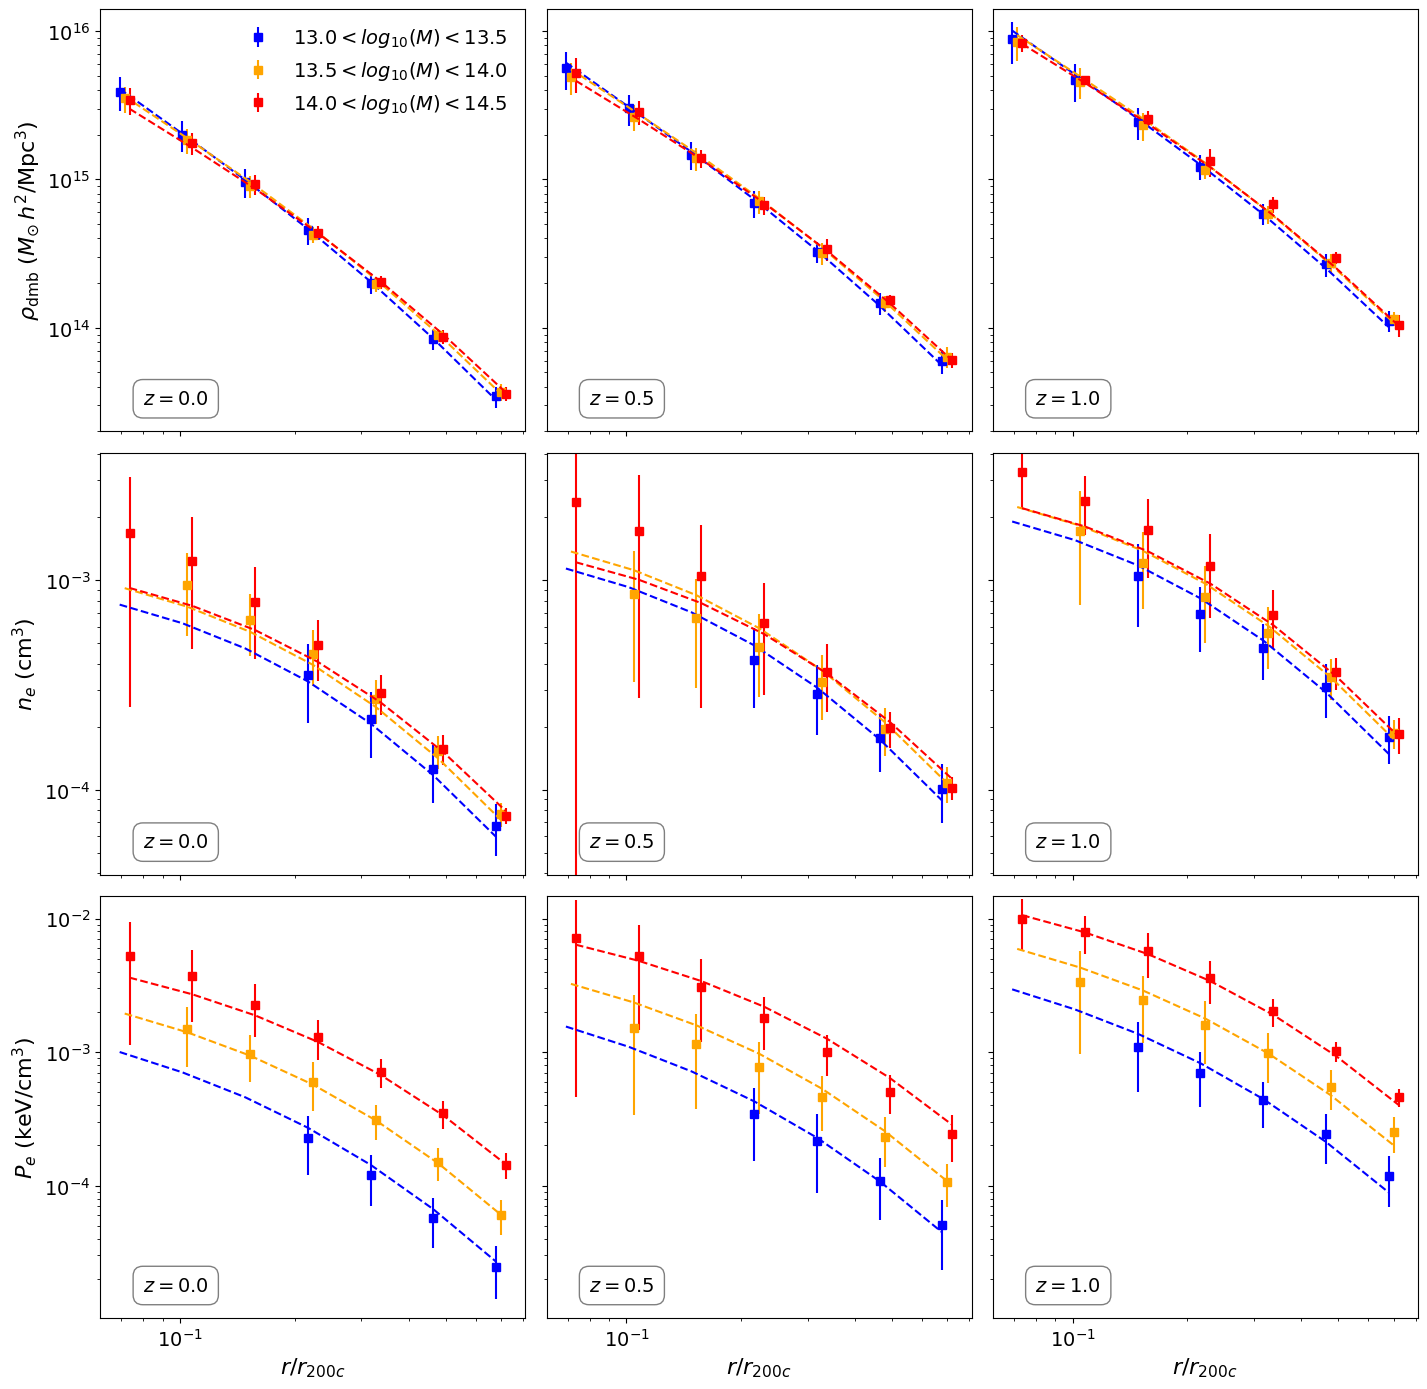

In [15]:
pl.figure()
fig, axes = pl.subplots(3, 3, figsize=(17, 17), sharex=True, sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
z_array_fit_plot = np.array([0.0, 0.5, 1.0])
for jp in range(3):
    for jz in range(3):
        indz = jz
        ax = axes[jp, jz]
        if jp == 0:
            ax.errorbar(0.97*x_array_data, rho_dmb_dv[indz,0,:], sig_rho_dmb_dv[indz,0,:],ls='', marker='s' , color='b', label=r'$13.0 < log_{10}(M) < 13.5$')
            ax.errorbar(0.97*x_array_data, rho_dmb_dv_th_bf[indz,0,:],ls='--' , color='b' )

            ax.errorbar(x_array_data, rho_dmb_dv[indz,1,:], sig_rho_dmb_dv[indz,1,:],ls='', marker='s', color='orange', label=r'$13.5 < log_{10}(M) < 14.0$')
            ax.errorbar(x_array_data, rho_dmb_dv_th_bf[indz,1,:],ls='--', color='orange' )

            ax.errorbar(1.03*x_array_data, rho_dmb_dv[indz,2,:], sig_rho_dmb_dv[indz,2,:],ls='', marker='s', color='r', label=r'$14.0 < log_{10}(M) < 14.5$')
            ax.errorbar(1.03*x_array_data, rho_dmb_dv_th_bf[indz,2,:],ls='--', color='r' )


            ax.set_xscale('log')
            ax.set_yscale('log')
            # change the size of the ticklabels:
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)
            # add text:
            ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
            if jp == 2:
                ax.set_xlabel(r'$r/r_{200c}$', size=16)
            if jz == 0:
                ax.legend(fontsize=14, frameon=False)                
                ax.set_ylabel(r'$\rho_{\rm dmb}$ ($M_{\odot} \, h^2 / {\rm Mpc}^3$)', size=16)
                ax.set_ylim(2e13, 1.4e16)

        if jp == 1:
            ax.errorbar(0.97*x_array_data, ne_dv[indz,0,:], sig_ne_dv[indz,0,:],ls='', marker='s' , color='b', label='Total mass, sims')
            ax.errorbar(0.97*x_array_data, rho_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

            ax.errorbar(x_array_data, ne_dv[indz,1,:], sig_ne_dv[indz,1,:],ls='', marker='s', color='orange', label='Gas mass, sims')
            ax.errorbar(x_array_data, rho_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

            ax.errorbar(1.03*x_array_data, ne_dv[indz,2,:], sig_ne_dv[indz,2,:],ls='', marker='s', color='r', label='Gas mass, sims')
            ax.errorbar(1.03*x_array_data, rho_gas_dv_th_bf[indz,2,:],ls='--', color='r' )

            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)            
            ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14,verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
            if jp == 2:
                ax.set_xlabel(r'$r/r_{200c}$', size=16)
            if jz == 0:
                ax.set_ylabel(r'$n_e$ (${\rm cm}^3$)', size=16)

        if jp == 2:
            ax.errorbar(0.97*x_array_data, Pe_dv[indz,0,:], sig_Pe_gas_dv[indz,0,:],ls='', marker='s' , color='b', label='Total mass, sims')
            ax.errorbar(0.97*x_array_data, Pth_gas_dv_th_bf[indz,0,:],ls='--' , color='b' , label='Theory')

            ax.errorbar(x_array_data, Pe_dv[indz,1,:], sig_Pe_gas_dv[indz,1,:],ls='', marker='s', color='orange', label='Gas mass, sims')
            ax.errorbar(x_array_data, Pth_gas_dv_th_bf[indz,1,:],ls='--', color='orange' )

            ax.errorbar(1.03*x_array_data, Pe_dv[indz,2,:], sig_Pe_gas_dv[indz,2,:],ls='', marker='s', color='r', label='Gas mass, sims')
            ax.errorbar(1.03*x_array_data, Pth_gas_dv_th_bf[indz,2,:],ls='--', color='r' )
            ax.text(0.1, 0.1, r'$z = $' + str(z_array_fit_plot[indz]), transform=ax.transAxes, fontsize=14, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)            
            if jp == 2:
                ax.set_xlabel(r'$r/r_{200c}$', size=16)
            if jz == 0:
                ax.set_ylabel(r'$P_e$ (${\rm keV} / {\rm cm}^3$)', size=16)


pl.tight_layout()
# pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/BCMP_18_wP_fit.pdf',bbox_inches='tight')






In [16]:
sim_params_dict_vary = copy.deepcopy(sim_params_dict)

for jp in range(len(params_vary_names)):
    sim_params_dict_vary[params_vary_names[jp]] = params[jp]

halo_params_dict_vary = copy.deepcopy(halo_params_dict)
halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 10.0, 15.5, 48


In [17]:
BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)






In [38]:
h = sim_params_dict_vary['cosmo']['H0'] / 100.0
Ob = sim_params_dict_vary['cosmo']['Ob0']
Om = sim_params_dict_vary['cosmo']['Om0']
import astropy.units as u
from astropy import constants as const
import jax_cosmo.background as bkgrd
import scipy.integrate as integrate
from setup_power_spectra_jit import setup_power_BCMP
sigmat = const.sigma_T
m_e = const.m_e
c = const.c
coeff = sigmat / (m_e * (c ** 2))
oneMpc_h_to_cm = (((10 ** 6)/h) * (u.pc).to(u.cm))
const_coeff = ((coeff).to(((u.kpc ** 2) / u.keV))).value


In [18]:

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict_vary, halo_params_dict_vary, analysis_dict, num_points_trapz_int=64)




In [40]:
Pk_sup = setup_power_BCMP_test.Pmm_sup_tot_mat
k_sup = setup_power_BCMP_test.k

k1 = 0.1
k2 = 0.5
k3 = 1.0
k4 = 4.0

indk1 = jnp.argmin(jnp.abs(k_sup - k1))
indk2 = jnp.argmin(jnp.abs(k_sup - k2))
indk3 = jnp.argmin(jnp.abs(k_sup - k3))
indk4 = jnp.argmin(jnp.abs(k_sup - k4))


In [26]:
M_test_noh = 1e14
M_test = M_test_noh * h
z_test = 0.0
# BCMP_test.rho_dmb_mat.shape

M_array = setup_power_BCMP_test.M_array
z_array = setup_power_BCMP_test.z_array
c_array = setup_power_BCMP_test.conc_array
indz = np.argmin(np.abs(z_array - z_test))
indM = np.argmin(np.abs(np.log10(M_array) - np.log10(M_test)))
# indc = 
c_test = setup_power_BCMP_test.conc_Mz_mat[indz, indM]
indc = np.argmin(np.abs(c_array - c_test))




0 34 11


In [41]:


r200c_Mz = BCMP_test.r200c_mat[indM, indz]
indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
r_array_j = BCMP_test.r_array[indsel_r]

rho_cga_j = BCMP_test.rho_cga_mat[indsel_r,indc, indz, indM]
rho_clm_j = BCMP_test.rho_clm_mat[indsel_r,indc, indz, indM]
rho_gas_j = BCMP_test.rho_gas_mat[indsel_r,indc, indz, indM]
rho_dmb_j = BCMP_test.rho_dmb_mat[indsel_r,indc, indz, indM]
rho_nfw_j = BCMP_test.rho_nfw_mat[indsel_r,indc, indz, indM]
Pe_mat_j = BCMP_test.Pe_mat_physical[indsel_r,indc, indz, indM]

Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
Y_int_j = const_coeff * Pe_int_j

Ez = np.sqrt(bkgrd.growth_factor(setup_power_BCMP_test.cosmo_jax, setup_power_BCMP_test.scale_fac_a_array))[indz]
M200_noh = M_array[indM]/h
h70 = h/0.7
Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
fb_ss = Ob/Om

fcga = BCMP_test.fcga_array[indM]
fstar = BCMP_test.fstar_array[indM]
fsga = fstar - fcga
fclm = BCMP_test.fclm_array[indM]

fgas_ltr200 = Mgas_int_j/Mdmb_int_j
fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
fcga_ltr200 = Mcga_int_j/Mdmb_int_j

fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200


print(fb_ltr200/fb_ss, Y_int_j/Y_ss, Pk_sup[indk1, indz], Pk_sup[indk2, indz], Pk_sup[indk3, indz], Pk_sup[indk4, indz])



0.8318376654559049 0.6809111792725021 0.9900368748885506 0.9808967927257622 0.9568927763445607 0.8669925177022825


In [36]:
# Y_ss



Array(3.38375642, dtype=float64)

In [20]:
Pk_nfw = setup_power_BCMP_test.Pmm_nfw_tot_mat
Pk_dmb = setup_power_BCMP_test.Pmm_dmb_tot_mat
Pk_sup = setup_power_BCMP_test.Pmm_sup_tot_mat



In [21]:
df_at = df_all_data[all_sims_names[jsim]][snap_num_fit[0]]
list(df_at.keys())




['r_r200c',
 'P_all',
 'ne_all',
 'M_hydro',
 'r200c_hydro',
 'rho_dm_all',
 'rho_dmb_all',
 'rho_gas_all',
 'rho_star_all',
 'M_dmo',
 'rel_diff',
 'lgmass_all',
 'group_number',
 'k_sup',
 'Pk_sup']

In [22]:
# snap_num_fit[2]
# jsimh = 20
# df_all_data[all_sims_names[jsimh]][32]['Pk_sup']/df_all_data[all_sims_names[jsimh]][26]['Pk_sup']




(0.7, 1.1)

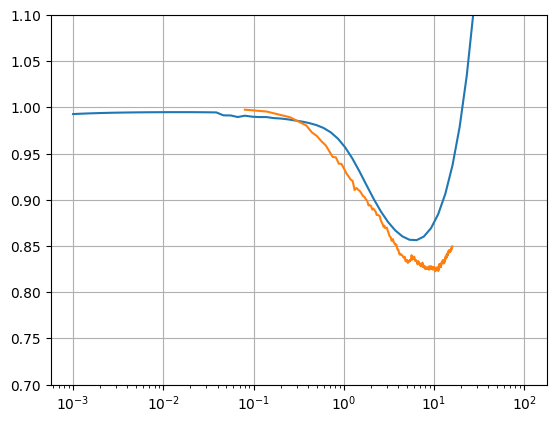

In [23]:
k_array = setup_power_BCMP_test.k
indz = 0


pl.figure()
pl.plot(k_array, Pk_sup[:,indz])
pl.plot(df_at['k_sup'], df_at['Pk_sup'])
# pl.plot(k_array, Pk_sup2[:,indz])
pl.xscale('log')
pl.grid()
pl.ylim(0.7, 1.1)




In [34]:
import pickle as pk
saved_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/Pksup_fb_Y_allsims.pkl','rb'))
all_sims_names = list(saved_all.keys())



In [35]:
df_sims_data = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/profiles_all_sims_all_snaps.pkl', 'rb'))



In [36]:
fb_fbSS_all = []
Y_YSS_all = []
Pk_sup_k1_all = []
Pk_sup_k2_all = []
Pk_sup_k3_all = []
Pk_sup_k4_all = []

Pk_sup_k1_all_sims = []
Pk_sup_k2_all_sims = []
Pk_sup_k3_all_sims = []
Pk_sup_k4_all_sims = []

k1 = 0.1
k2 = 0.5
k3 = 1.0
k4 = 4.0

for sim in all_sims_names:
    df_at = saved_all[sim]
    fb_fbSS_all.append(df_at['fb_fbSS'])
    Y_YSS_all.append(df_at['Y_YSS'])

    df_sims = df_sims_data[sim][32]
    k_sup_sim = df_sims['k_sup']
    Pk_sup_sim = df_sims['Pk_sup']
    ind_k1 = np.argmin(np.abs(k_sup_sim - k1))
    ind_k2 = np.argmin(np.abs(k_sup_sim - k2))
    ind_k3 = np.argmin(np.abs(k_sup_sim - k3))
    ind_k4 = np.argmin(np.abs(k_sup_sim - k4))
    Pk_sup_k1_all_sims.append(Pk_sup_sim[ind_k1])
    Pk_sup_k2_all_sims.append(Pk_sup_sim[ind_k2])
    Pk_sup_k3_all_sims.append(Pk_sup_sim[ind_k3])
    Pk_sup_k4_all_sims.append(Pk_sup_sim[ind_k4])

    Pk_sup_k1_all.append(df_at['Pk_sup_k1'])
    Pk_sup_k2_all.append(df_at['Pk_sup_k2'])
    Pk_sup_k3_all.append(df_at['Pk_sup_k3'])
    Pk_sup_k4_all.append(df_at['Pk_sup_k4'])



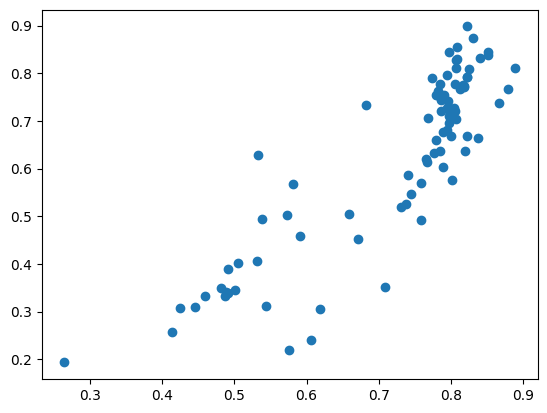

In [15]:
pl.figure()
pl.plot(fb_fbSS_all, Y_YSS_all, 'o')


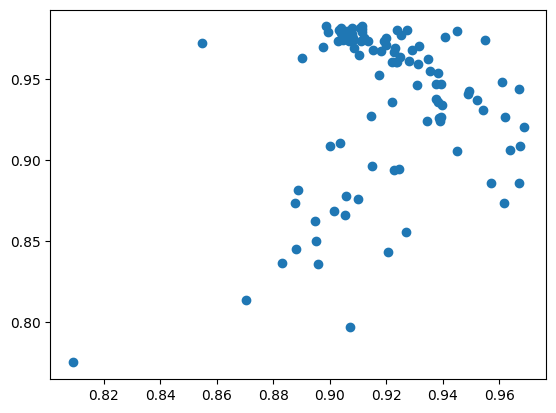

In [27]:
pl.figure()
# pl.plot(Pk_sup_k1_all, Pk_sup_k1_all_sims, 'o')
# pl.plot(Pk_sup_k2_all, Pk_sup_k2_all_sims, 'o')
pl.plot(Pk_sup_k3_all, Pk_sup_k3_all_sims, 'o')
# pl.plot(Pk_sup_k4_all, Pk_sup_k4_all_sims, 'o')



In [38]:
def Pk_sup_vd(fb, k):
    a, b, c, d, e = 2.111, 0.0038, 1.371, -5.816, -0.4005
    num = 2**a + 2**b * (c * fb)**(b-a)
    denom = k**(-a) + (c * fb)**(b-a) * k**(-b)
    exp_fac = np.exp(d*fb + e)
    val = 1 - num * exp_fac/denom
    return val

fb_arr = np.linspace(0.2, 1.0, 100)
k1 = 0.1
k2 = 0.5
k3 = 1.0
k4 = 4.0
Pk_sup_k1_vd = Pk_sup_vd(fb_arr, k1)
Pk_sup_k2_vd = Pk_sup_vd(fb_arr, k2)
Pk_sup_k3_vd = Pk_sup_vd(fb_arr, k3)
Pk_sup_k4_vd = Pk_sup_vd(fb_arr, k4)



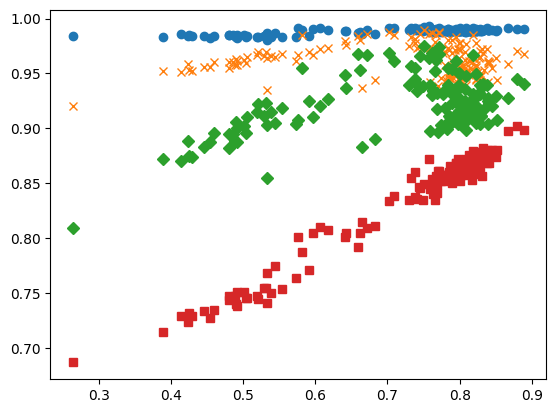

In [39]:
pl.figure()
pl.plot(fb_fbSS_all, Pk_sup_k1_all, 'o')
# pl.plot(fb_arr, Pk_sup_k1_vd)
pl.plot(fb_fbSS_all, Pk_sup_k2_all, 'x')
# pl.plot(fb_arr, Pk_sup_k2_vd)
pl.plot(fb_fbSS_all, Pk_sup_k3_all, 'D')
# pl.plot(fb_arr, Pk_sup_k3_vd)
pl.plot(fb_fbSS_all, Pk_sup_k4_all, 's')
# pl.plot(fb_arr, Pk_sup_k4_vd)




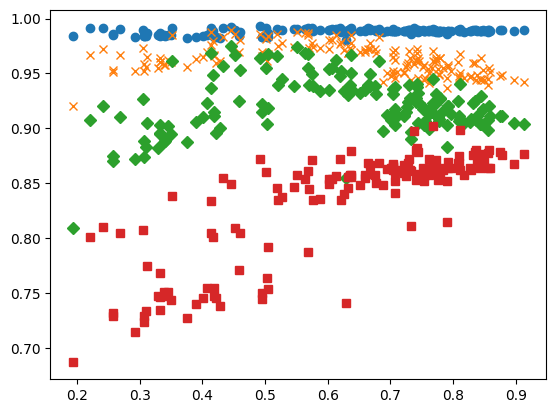

In [40]:
pl.figure()
pl.plot(Y_YSS_all, Pk_sup_k1_all, 'o')
pl.plot(Y_YSS_all, Pk_sup_k2_all, 'x')
pl.plot(Y_YSS_all, Pk_sup_k3_all, 'D')
pl.plot(Y_YSS_all, Pk_sup_k4_all, 's')
